# Selling Iron Butterflies Immediately Before Earnings
### Edward Yudolevich
#### QFS Quant Summer Project

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
import zipfile
import py_vollib.black_scholes_merton.implied_volatility
import py_vollib.black_scholes.greeks.numerical
import py_vollib_vectorized
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.style.use('seaborn-dark')
import seaborn as sns
import scipy.stats as stats

# Background

First, a quick technical note: this project requires an understanding of the following concepts, and information about these concepts if they are new can be found at the links provided:

1. Options in general, and OTM vs ATM vs ITM. See: https://www.investopedia.com/terms/s/stockoption.asp and https://www.learningmarkets.com/choosing-at-the-money-in-the-money-or-out-of-the-money-options/
3. Implied volatility. See: https://www.investopedia.com/terms/i/iv.asp
2. Vega. See: https://www.investopedia.com/terms/v/vega.asp
3. Volatility surfaces, skews, and smiles. See: https://www.investopedia.com/articles/stock-analysis/081916/volatility-surface-explained.asp and https://www.theoptionsguide.com/volatility-smile.aspx
4. Iron butterflies. See: https://www.optionsplaybook.com/option-strategies/iron-butterfly/

The idea for this project originated when I was running various tests to check for patterns in options chains on S&P equities around earnings. After much trial and error, I came across the statistical anomaly that is shown below regarding changes in the slope of the volatility smile before and after earnings. The way that I am calculating the slope of the smile is:

Slope = (IV on 90% Moneyness Put + IV on 110% Moneyness Call) / (IV on 100% Moneyness Put + IV on 100% Moneyness Call)

In the section below, 'Before Earnings' is 5 business days before the earnings call and 'At Earnings' is the market close right before the earnings call, and 'After Earnings' is 5 business days after the earnings call. So, for example, a positive result for 'Change in Smile After Earnings' indicates that the volatility smile (as defined above) increased from the market close right before earnings to the market close 5 business days later. Also note that I am using a constant expiry which is roughly 2-3 weeks after the earnings call. If not interested in reading code, scroll down to see the density plots that are the results of this test.

# Changes in Volatility Smile Before and After Earnings

In [2]:
def import_data(ticker):

    '''Import Options Data That Has Already Been Cleaned'''
    
    directory = r"D:\Selected_Option_Data"
    files = os.listdir(directory)
    first_words = []
    for file in files:
        first_word = file.split()[0]
        first_words.append(first_word)
    index = first_words.index(ticker)
    file_name = files[index]
    file_location = os.path.join(directory, file_name)
    
    df = pd.read_csv(file_location)
    df['DataDate'] = pd.to_datetime(df['DataDate'])
    df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'])
    
    return df

In [3]:
def market_days(df, earnings_date, bmo):
    
    '''Get list of trading days and make earnings_date into datetime and so that the earnings_date is always 
    BEFORE the earnings call'''
    
    trading_days = df['DataDate'].unique()
    earnings_date = pd.to_datetime(earnings_date)
    assert earnings_date in trading_days
    if bmo == True:
        earnings_date_index = np.where(trading_days == earnings_date)[0][0]
        earnings_date = trading_days[earnings_date_index - 1]
        earnings_date = pd.to_datetime(earnings_date)
    
    return trading_days, earnings_date

In [4]:
def optimal_expiry(df, earnings_date, min_days_expiry, trading_days):
    
    '''Determine which option tenor to work with'''
    
    earnings_date_index = np.where(trading_days == earnings_date)[0][0]
    min_expiry = trading_days[earnings_date_index + min_days_expiry]
    df1 = df[df['DataDate'] >= min_expiry]
    df1 = df1.iloc[(df1['DTE']).abs().argmin()]
    expiry = df1['ExpirationDate']
    
    return expiry

In [5]:
def smile_calc(df):
    
    '''Calculate skew on a given day using original skew formula where df is already filtered by expiry and data date'''
    
    atm_put = df.iloc[(df['Delta'] + 0.5).abs().argmin()]
    atm_put_iv = float(atm_put['ImpliedVolatility'])
    atm_call = df.iloc[(df['Delta'] - 0.5).abs().argmin()]
    atm_call_iv = float(atm_call['ImpliedVolatility'])
    atm_vol = (atm_put_iv + atm_call_iv) / 2
    
    df['StrikeProp'] = df['StrikePrice'] / df['UnderlyingPrice']
    df_puts = df[df['PutCall'] == 'put']
    otm_put = df_puts.iloc[(df_puts['StrikeProp'] - 0.9).abs().argmin()]
    otm_put_iv = float(otm_put['ImpliedVolatility'])
    df_calls = df[df['PutCall'] == 'call']
    otm_call = df_calls.iloc[(df_calls['StrikeProp'] - 1.1).abs().argmin()]
    otm_call_iv = float(otm_call['ImpliedVolatility'])
    otm_vol = (otm_put_iv + otm_call_iv) / 2
    
    smile = otm_vol / atm_vol
    
    return smile

In [6]:
def smile(df, earnings_date, trading_days, expiry):
    
    '''Calculate change in basic calc of skew a week before to earnings and then earnings to a week after earnings'''
    
    df1 = df[df['ExpirationDate'] == expiry]
    df1 = df1[df1['BidPrice'] > 0]
    df1 = df1[df1['AskPrice'] > 0]
    df1 = df1[df1['BidSize'] > 0]
    df1 = df1[df1['AskSize'] > 0]
    
    earnings_date_index = np.where(trading_days == earnings_date)[0][0]
    before_date = trading_days[earnings_date_index - 5]
    after_date = trading_days[earnings_date_index + 4]
    
    df_before = df1[df1['DataDate'] == before_date]
    df_after = df1[df1['DataDate'] == after_date]
    df_earnings = df1[df1['DataDate'] == earnings_date]
    
    before_smile = smile_calc(df_before)
    after_smile = smile_calc(df_after)
    earnings_smile = smile_calc(df_earnings)
    
    change_before = earnings_smile - before_smile
    change_after = after_smile - earnings_smile
    
    return change_before, change_after

In [7]:
# will be using 10 business days mininum expiry throughout testing
min_days_expiry = 10

# import earnings calendar which was scraped from BamSEC with Wenxuan's help
earnings = pd.read_csv('Top 250 Earnings Calendar.csv')
earnings['Date'] = pd.to_datetime(earnings['Date'])
earnings = earnings[earnings['Date'] <= '2022-06-01']
earnings = earnings[earnings['Date'] >= '2018-02-01']

# create list of option files to confirm that file exists before trying to import it
directory = r"D:\Selected_Option_Data"
files = os.listdir(directory)
tickers_files = []
for file in files:
    first_word = file.split()[0]
    tickers_files.append(first_word)

current_ticker = ''
df_results = pd.DataFrame(columns = ['Ticker', 'Earnings Date', 'Smile Change Before Earnings', 'Smile Change After Earnings'])

# loop through every earnings date in calendar 
for i in range(len(earnings)):
    
    # no use in re-importing if we are still working with the same ticker
    ticker = earnings['Ticker'].iloc[i]
    if ticker in tickers_files:
        if current_ticker != ticker:
            df = import_data(ticker)
            current_ticker = ticker
    else:
        continue
    
    # always want to be looking at the market close BEFORE the earnings call
    earnings_date = earnings['Date'].iloc[i]
    bmo = False
    if earnings['Time'].iloc[i] == 'bmo':
        bmo = True
    
    try: # to check if earnings_date is a business day
        trading_days, earnings_date = market_days(df, earnings_date, bmo)
    except:
        continue
    
    expiry = optimal_expiry(df, earnings_date, min_days_expiry, trading_days)
    
    try: # to make sure that the option was being quoted long enough before to have an entry a week before earnings
        change_before, change_after = smile(df, earnings_date, trading_days, expiry)
    except:
        continue
    
    df_results.loc[len(df_results)] = [ticker, earnings_date, change_before, change_after]

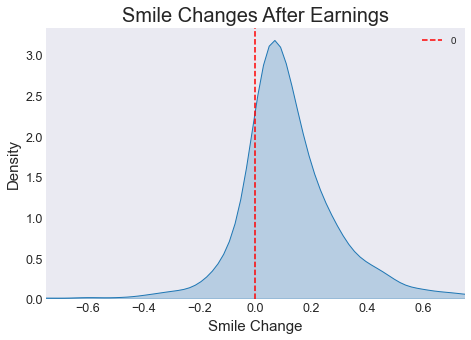

The T-Stat for whether the 'Smile Changes AFTER Earnings' distribution is significantly different from 0 is 35.95


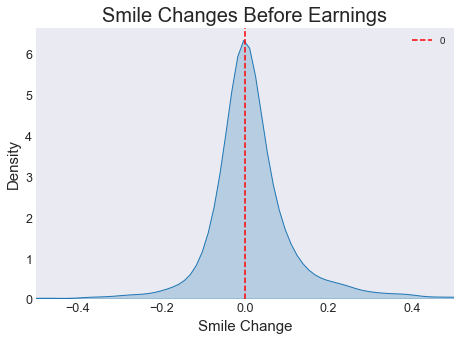

The T-Stat for whether the 'Smile Changes BEFORE Earnings' distribution is significantly different from 0 is 10.22


In [8]:
plt.figure(figsize = (7.5, 5))
ax = sns.kdeplot(df_results['Smile Change After Earnings'], shade = True)
plt.xlim([-0.75, 0.75])
ax.axvline(0, color = 'red', linestyle = 'dashed', label = 0)
plt.xlabel('Smile Change', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Smile Changes After Earnings', fontsize = 20)
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.legend()
plt.show()
t_stat_after = stats.ttest_1samp(a = df_results['Smile Change After Earnings'], popmean = 0)[0]
print(f"The T-Stat for whether the 'Smile Changes AFTER Earnings' distribution is significantly different from 0 is {t_stat_after:.4}")

plt.figure(figsize = (7.5, 5))
ax = sns.kdeplot(df_results['Smile Change Before Earnings'], shade = True)
plt.xlim([-0.5, 0.5])
ax.axvline(0, color = 'red', linestyle = 'dashed', label = 0)
plt.xlabel('Smile Change', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Smile Changes Before Earnings', fontsize = 20)
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.legend()
plt.show()
t_stat_before = stats.ttest_1samp(a = df_results['Smile Change Before Earnings'], popmean = 0)[0]
print(f"The T-Stat for whether the 'Smile Changes BEFORE Earnings' distribution is significantly different from 0 is {t_stat_before:.4}")

The mean of "Smile Changes After Earnings" seems to be very statistically significantly greater than 0. Given the way that I am defining the slope of the smile, it is therefore logical to think about selling Iron Butterflies right before earnings and buying them back a week later (because you are short ATM vol and long OTM vol). However, before backtesting this, it is important to determine whether the indicated smile relationship (on average) holds true when keeping constant strikes, because the above charts are always looking at the nearest contracts to 90% and 110% moneyness. Instead, I now need to see if the options that are OTM at entry right before earnings will typically increase in IV and options that are ATM at entry right before earnings will typically decrease in IV.

# Checking IV Changes Keeping Constant Strikes

In [9]:
def entry_vol(df, earnings_date, expiry):
    
    '''Determine contract specifications and IV on entry'''
    
    df1 = df[df['ExpirationDate'] == expiry]
    df1 = df[df['DataDate'] == earnings_date]
    df1['StrikeProp'] = df1['StrikePrice'] / df['UnderlyingPrice']
    df1['ImpliedVolatility'].fillna(0, inplace = True)
    
    df_puts = df1[df1['PutCall'] == 'put']
    otm_put = df_puts.iloc[(df_puts['StrikeProp'] - 0.9).abs().argmin()]
    otm_put_strike = otm_put['StrikePrice']
    otm_put_iv = float(otm_put['ImpliedVolatility'])
    otm_put_vega = float(otm_put['Vega'])

    atm_put = df_puts.iloc[(df_puts['StrikeProp'] - 1).abs().argmin()]
    atm_put_strike = atm_put['StrikePrice']
    atm_put_iv = float(atm_put['ImpliedVolatility'])
    atm_put_vega = float(otm_put['Vega'])
    
    df_calls = df1[df1['PutCall'] == 'call']
    otm_call = df_calls.iloc[(df_calls['StrikeProp'] - 1.1).abs().argmin()]
    otm_call_strike = otm_call['StrikePrice']
    otm_call_iv = float(otm_call['ImpliedVolatility'])
    otm_call_vega = float(otm_call['Vega'])

    atm_call = df_calls.iloc[(df_calls['StrikeProp'] - 1).abs().argmin()]
    atm_call_strike = atm_call['StrikePrice']
    atm_call_iv = float(atm_call['ImpliedVolatility'])
    atm_call_vega = float(atm_call['Vega'])
    
    otm_vol_entry = (otm_put_iv + otm_call_iv) / 2
    atm_vol_entry = (atm_put_iv + atm_call_iv) / 2
    vega_ratio = ((atm_call_vega + atm_put_vega)/2) / ((otm_put_vega + otm_call_vega)/2)
    
    return atm_vol_entry, otm_vol_entry, atm_call_strike, atm_put_strike, otm_call_strike, otm_put_strike, vega_ratio

In [10]:
def exit_vol(df, earnings_date, trading_days, expiry, atm_call_strike, atm_put_strike, otm_call_strike, otm_put_strike):
    
    '''Find change in IV on specific contracts that were entered'''
    
    df1 = df[df['ExpirationDate'] == expiry]
    earnings_date_index = np.where(trading_days == earnings_date)[0][0]
    exit_date = trading_days[earnings_date_index + 5]
    df1 = df1[df1['DataDate'] == exit_date]
    df1['ImpliedVolatility'].fillna(0, inplace = True)
    
    df_puts = df1[df1['PutCall'] == 'put']
    atm_put = df_puts[df_puts['StrikePrice'] == atm_put_strike]
    atm_put_iv = atm_put['ImpliedVolatility'].iloc[0]

    otm_put = df_puts[df_puts['StrikePrice'] == otm_put_strike]
    otm_put_iv = otm_put['ImpliedVolatility'].iloc[0]   
    
    df_calls = df1[df1['PutCall'] == 'call']
    atm_call = df_calls[df_calls['StrikePrice'] == atm_call_strike]
    atm_call_iv = atm_call['ImpliedVolatility'].iloc[0]

    otm_call = df_calls[df_calls['StrikePrice'] == otm_call_strike]
    otm_call_iv = otm_call['ImpliedVolatility'].iloc[0]
    
    otm_vol_exit = (otm_put_iv + otm_call_iv) / 2
    atm_vol_exit = (atm_put_iv + atm_call_iv) / 2
    
    return otm_vol_exit, atm_vol_exit

In [11]:
current_ticker = ''
df_results = pd.DataFrame(columns = ['Ticker', 'Earnings Date', 'ATM Vol Change', 'OTM Vol Change', 'Vega Ratio'])

for i in range(len(earnings)):

    ticker = earnings['Ticker'].iloc[i]
    if ticker in tickers_files:
        if current_ticker != ticker:
            df = import_data(ticker)
            current_ticker = ticker
    else:
        continue

    earnings_date = earnings['Date'].iloc[i]
    bmo = False
    if earnings['Time'].iloc[i] == 'bmo':
        bmo = True
    
    try: # to check if earnings_date is a business day
        trading_days, earnings_date = market_days(df, earnings_date, bmo)
    except:
        continue
    
    expiry = optimal_expiry(df, earnings_date, min_days_expiry, trading_days)
    
    atm_vol_entry, otm_vol_entry, atm_call_strike, atm_put_strike, otm_call_strike, otm_put_strike, vega_ratio = entry_vol(df, earnings_date, expiry)
    
    try: # sometimes that are errors in the data and that contract is not quoted on the desired day
        otm_vol_exit, atm_vol_exit = exit_vol(df, earnings_date, trading_days, expiry, atm_call_strike, atm_put_strike, otm_call_strike, otm_put_strike)
    except:
        continue
        
    otm_vol_change = otm_vol_exit - otm_vol_entry
    atm_vol_change = atm_vol_exit - atm_vol_entry
    
    df_results.loc[len(df_results)] = [ticker, earnings_date, atm_vol_change, otm_vol_change, vega_ratio]

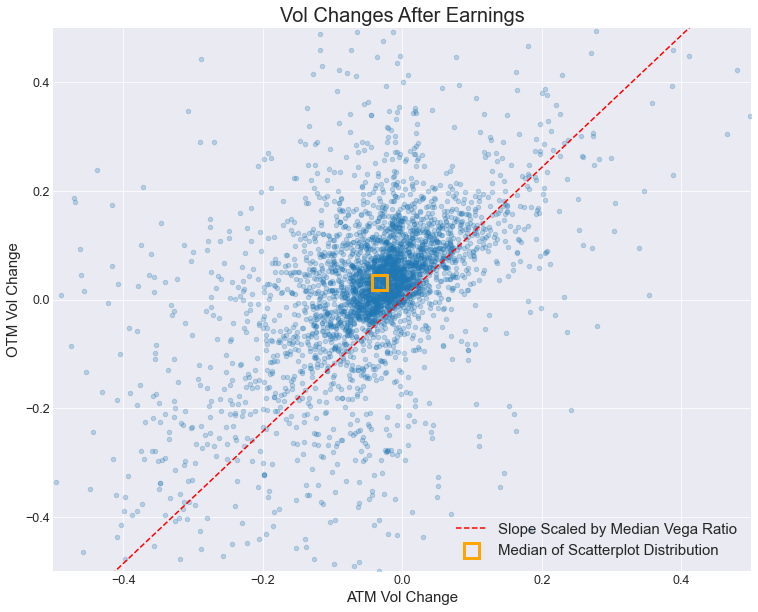

In [12]:
ax = df_results.plot(kind = 'scatter', x = 'ATM Vol Change', y = 'OTM Vol Change', alpha = 0.25, figsize = (12.5, 10), grid = True)
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
xpoints = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1])
ypoints = df_results['Vega Ratio'].median()*xpoints
ax.plot(xpoints, ypoints, linestyle='--', color='red', scalex=False, scaley=False, label = 'Slope Scaled by Median Vega Ratio')
ax.plot(df_results['ATM Vol Change'].median(), df_results['OTM Vol Change'].median(), 'ks', ms = 15, markerfacecolor = 'none', markeredgecolor = 'orange', markeredgewidth = 3, label = 'Median of Scatterplot Distribution')
ax.legend(fontsize = 15)
plt.xlabel('ATM Vol Change', fontsize = 15)
plt.ylabel('OTM Vol Change', fontsize = 15)
plt.title('Vol Changes After Earnings', fontsize = 20)
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.show()

This chart tells us several things. Options that were ATM right before earnings do tend to lose IV points in the following week, and options that were OTM right before earnings do tend to gain IV points in the following week. Moreover, although it is a very generalized and rough statement, you can *kind of* say that all the points to the left/above the red line are points that represent a successful demonstration of the edge: if the ATM Vol Change is less than the (OTM Vol Change / Ratio of Vega Values), then the IV moves on the composite option position were in our favor. Now that this edge has been determined, we can proceed to a backtest. First, I will test the success of this strategy if it is was systematically entered on every earnings date. Note that this backtest assumes that I am always crossing the bid-ask spread both on entry and exit, which is a very significant and conservative assumption when backtesting an options strategy.

# Backtest Entry on All Days

In [13]:
def entry(df, earnings_date, expiry):
    
    '''Determine contract specifications and price on entry'''
    
    df1 = df[df['ExpirationDate'] == expiry]
    df1 = df[df['DataDate'] == earnings_date]
    df1['StrikeProp'] = df1['StrikePrice'] / df['UnderlyingPrice']
    df1['ImpliedVolatility'].fillna(0, inplace = True)
    df1['1/4'] = (df1['BidPrice'] + df1['MidPrice']) / 2
    df1['3/4'] = (df1['MidPrice'] + df1['AskPrice']) / 2
    
    df_puts = df1[df1['PutCall'] == 'put']
    otm_put = df_puts.iloc[(df_puts['StrikeProp'] - 0.9).abs().argmin()]
    otm_put_strike = otm_put['StrikePrice']
    otm_put_entry = float(otm_put['AskPrice'])
    otm_put_iv = float(otm_put['ImpliedVolatility'])
    
    atm_put = df_puts.iloc[(df_puts['StrikeProp'] - 1).abs().argmin()]
    atm_put_strike = atm_put['StrikePrice']
    atm_put_entry = float(atm_put['BidPrice'])
    atm_put_iv = float(atm_put['ImpliedVolatility'])
    
    df_calls = df1[df1['PutCall'] == 'call']
    otm_call = df_calls.iloc[(df_calls['StrikeProp'] - 1.1).abs().argmin()]
    otm_call_strike = otm_call['StrikePrice']
    otm_call_entry = float(otm_call['AskPrice'])
    otm_call_iv = float(otm_call['ImpliedVolatility'])

    atm_call = df_calls.iloc[(df_calls['StrikeProp'] - 1).abs().argmin()]
    atm_call_strike = atm_call['StrikePrice']
    atm_call_entry = float(atm_call['BidPrice'])
    atm_call_iv = float(atm_call['ImpliedVolatility'])
    
    atm_vol = (atm_put_iv + atm_call_iv) / 2
    otm_vol = (otm_put_iv + otm_call_iv) / 2

    skew = otm_vol / atm_vol
    
    underlying = float(atm_call['UnderlyingPrice'])
    
    return atm_vol, skew, atm_call_entry, atm_put_entry, otm_call_entry, otm_put_entry, atm_call_strike, atm_put_strike, otm_call_strike, otm_put_strike, underlying

In [14]:
def exit(df, earnings_date, trading_days, expiry, atm_call_strike, atm_put_strike, otm_call_strike, otm_put_strike):
    
    '''Find exit prices for specified contracts'''
    
    df1 = df[df['ExpirationDate'] == expiry]
    earnings_date_index = np.where(trading_days == earnings_date)[0][0]
    exit_date = trading_days[earnings_date_index + 5]
    df1 = df1[df1['DataDate'] == exit_date]
    df1['1/4'] = (df1['BidPrice'] + df1['MidPrice']) / 2
    df1['3/4'] = (df1['MidPrice'] + df1['AskPrice']) / 2
    
    df_puts = df1[df1['PutCall'] == 'put']
    atm_put = df_puts[df_puts['StrikePrice'] == atm_put_strike]
    atm_put_exit = atm_put['AskPrice'].iloc[0]

    otm_put = df_puts[df_puts['StrikePrice'] == otm_put_strike]
    otm_put_exit = otm_put['BidPrice'].iloc[0]   
    
    df_calls = df1[df1['PutCall'] == 'call']
    atm_call = df_calls[df_calls['StrikePrice'] == atm_call_strike]
    atm_call_exit = atm_call['AskPrice'].iloc[0]

    otm_call = df_calls[df_calls['StrikePrice'] == otm_call_strike]
    otm_call_exit = otm_call['BidPrice'].iloc[0]

    
    return atm_call_exit, atm_put_exit, otm_call_exit, otm_put_exit, exit_date

In [15]:
current_ticker = ''
df_results = pd.DataFrame(columns = ['Ticker', 'Earnings Date', 'PnL', 'Cost Basis', 'ATM Call Price', 'ATM Vol', 'Skew', 'Underlying Price', 'Margin'])

for i in range(len(earnings)):
    
    ticker = earnings['Ticker'].iloc[i]
    if ticker in tickers_files:
        if current_ticker != ticker:
            df = import_data(ticker)
            current_ticker = ticker
    else:
        continue
    
    earnings_date = earnings['Date'].iloc[i]
    bmo = False
    if earnings['Time'].iloc[i] == 'bmo':
        bmo = True
    
    try: # to check if earnings_date is a business day
        trading_days, earnings_date = market_days(df, earnings_date, bmo)
    except:
        continue
    
    expiry = optimal_expiry(df, earnings_date, min_days_expiry, trading_days)
    
    atm_vol, skew, atm_call_entry, atm_put_entry, otm_call_entry, otm_put_entry, atm_call_strike, atm_put_strike, otm_call_strike, otm_put_strike, underlying = entry(df, earnings_date, expiry)
    
    try: # sometimes that are errors in the data and that contract is not quoted on the desired day
        atm_call_exit, atm_put_exit, otm_call_exit, otm_put_exit, exit_date = exit(df, earnings_date, trading_days, expiry, atm_call_strike, atm_put_strike, otm_call_strike, otm_put_strike)
    except:
        continue
    
    # calculate raw pnl
    pnl = (atm_call_entry - atm_call_exit) + (atm_put_entry - atm_put_exit) + (otm_call_exit - otm_call_entry) + (otm_put_exit - otm_put_entry)
    # determine entry cost basis
    cost_basis = (atm_call_entry + atm_put_entry) - (otm_call_entry + otm_put_entry)
    # determine required invested capital = margin
    max_loss = max(otm_call_strike - atm_call_strike, atm_put_strike - otm_put_strike)
    margin = max_loss - cost_basis
    
    df_results.loc[len(df_results)] = [ticker, earnings_date, pnl, cost_basis, atm_call_entry, atm_vol, skew, underlying, margin]

In [16]:
df_results = df_results.sort_values(by = 'Earnings Date')

df_results = df_results[df_results['Cost Basis'] > 0] # wouldn't enter a position that doesn't provide credit
df_results = df_results[df_results['Margin'] > 0] # anything less than 0 is arbitrage

df_results['% PnL'] = df_results['PnL'] / df_results['Margin']

# less than -1 shouldn't be possible given definition of margin = max loss. greater than 1 is possible but for conservatism
# I am using 1. This actually reduces upside more than downside. before this, the max loser is -~2.5x, but there are plenty of 
# winners far above +2.5x.
df_results['% PnL'] = df_results['% PnL'].clip(-1, 1)

# scale according to mean number of trades per week multipled by 25 to account for clustering around earnings (very conservative)
years = (pd.to_datetime(df_results['Earnings Date'].iloc[-1]) - pd.to_datetime(df_results['Earnings Date'].iloc[0]))/np.timedelta64(1, 'Y')
scaler = (len(df_results)/(52*years)) * 25

# generate portfolio simulation
df_results['Scaled %'] = 1 + df_results['% PnL'] / scaler 
df_results['Port'] = df_results['Scaled %'].cumprod()

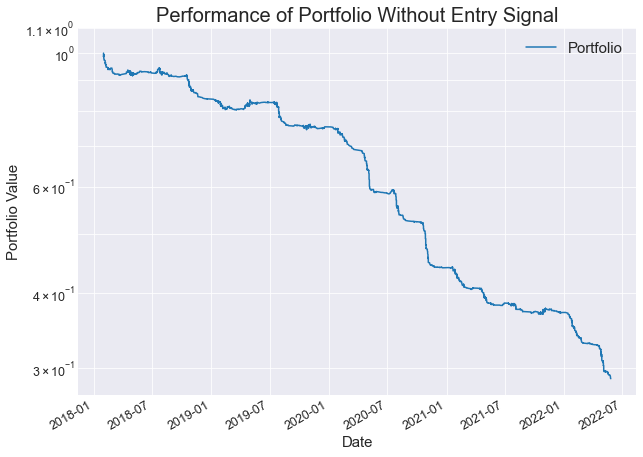

The Sharpe is -7.31
The win-rate without entry signal is 37.33%


In [17]:
# plot raw strategy performance
ax = df_results.plot(x = 'Earnings Date', y = 'Port', figsize = (10, 7.5), grid = True)
list1 = ax.get_yticks()[1:]
plt.yscale('log')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Portfolio Value', fontsize = 15)
plt.title('Performance of Portfolio Without Entry Signal', fontsize = 20)
plt.xticks(fontsize = 12.5)
plt.yticks(list1, fontsize = 12.5)
plt.legend(['Portfolio'], fontsize = 15)
plt.show()

# print sharpe and win rate
annual_return = df_results['Port'].iloc[-1] ** (1/years) - 1
mean_trades_per_year = len(df_results) / years
stdev = df_results['Scaled %'].std() * np.sqrt(mean_trades_per_year)
sharpe = (annual_return - 0.03) / stdev
print(f"The Sharpe is {sharpe:.4}")

df_wins = df_results[df_results['PnL'] > 0]
win_rate = len(df_wins) / len(df_results)
print(f"The win-rate without entry signal is {win_rate:.2%}")

This chart looks absolutely horrible, but given the fact that we are constantly crossing spread on 4 options with only a week-long holding period, this is actually not that bad. However, it is clear that this strategy needs an entry signal.

# Finding Entry Signal

One possibility for creating a mathematical manner of the checking relative quality of our entry point is to use the ratio: (credit received on entry) / (price of stock). A human trader would not enter positions where the credit received was minimal relative to the option prices and to the price of the stock. Moreover, using such a measure has a strength that is two-fold: since we are scaling the sizing of each position relative to the margin requirement (which is inversely related with the credit received on entry), a greater credit received on entry is likely to have a higher return on invested capital. Let's plot the relationship between this ratio and the % PnL.

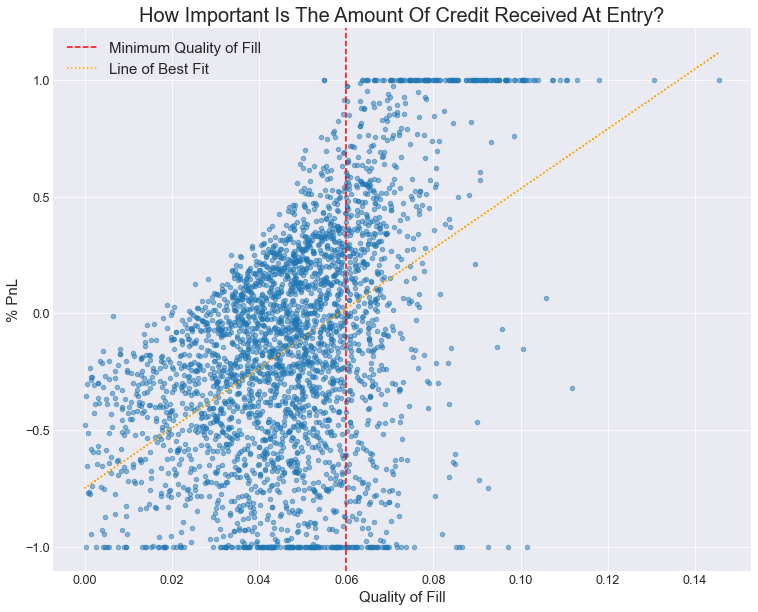

The regression test between these two variables has an R-Sqaured value of 23.09% and an F-Stat of 940.08


In [18]:
# create column for how good the fill is relative to stock price
df_results['Quality of Cost Basis'] = df_results['Cost Basis'] / df_results['Underlying Price']
df_results = df_results[df_results['Quality of Cost Basis'] < 0.15] # remove one weird outlier

# plot
ax = df_results.plot(kind = 'scatter', x = 'Quality of Cost Basis', y = '% PnL', alpha = 0.5, figsize = (12.5, 10), grid = True)
ax.axvline(0.06, color = 'red', linestyle = 'dashed', label = 'Minimum Quality of Fill')
plt.xlabel('Quality of Fill', fontsize = 15)
plt.ylabel('% PnL', fontsize = 15)
plt.title('How Important Is The Amount Of Credit Received At Entry?', fontsize = 20)
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
m, b = np.polyfit(df_results['Quality of Cost Basis'], df_results['% PnL'], 1)
plt.plot(df_results['Quality of Cost Basis'], m*df_results['Quality of Cost Basis'] + b, color = 'orange', label = 'Line of Best Fit', linestyle = 'dotted')
plt.legend(fontsize = 15)
plt.show()

# check if variables are relevant
import statsmodels.api as sm
X = df_results['Quality of Cost Basis']
y = df_results['% PnL']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(f'The regression test between these two variables has an R-Sqaured value of {model.rsquared:.2%} and an F-Stat of {model.fvalue:.5}')

The number 0.06 as a minimum 'Quality of Fill' was chosen arbitrarily after looking at the raw scatterplot, and consequently there might be some overfitting going on, but using a slightly different value does not significantly affect the results shown below. Moreover, the reasonably strong R-Squared value and F-Stat demonstrate the robustness of this signal. Now I will test this strategy when entering only if the (credit received on entry) / (stock price) > 6%. 

# Backtest With Filter

In [19]:
previous_len = len(df_results)
df_results = df_results[df_results['Quality of Cost Basis'] > 0.06]
new_len = len(df_results)
entry_rate = new_len / previous_len
scaler = (len(df_results)/(52*years)) * 25
df_results['Scaled %'] = 1 + df_results['% PnL'] / scaler
df_results = df_results.sort_values(by = 'Earnings Date')
df_results['Port'] = df_results['Scaled %'].cumprod()
print(f"The signal has an entry-rate of {entry_rate:.2%}")

The signal has an entry-rate of 23.40%


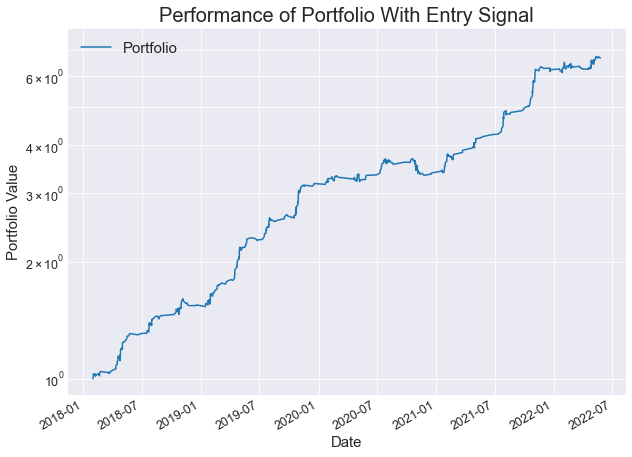

The Sharpe is 5.339
The win-rate with entry signal is 65.89%


In [20]:
# plot new strategy performance
ax = df_results.plot(x = 'Earnings Date', y = 'Port', figsize = (10, 7.5), grid = True)
list1 = ax.get_yticks()[1:]
plt.yscale('log')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Portfolio Value', fontsize = 15)
plt.title('Performance of Portfolio With Entry Signal', fontsize = 20)
plt.xticks(fontsize = 12.5)
plt.yticks(list1, fontsize = 12.5)
plt.legend(['Portfolio'], fontsize = 15)
plt.show()

# get performance measures
annual_return = df_results['Port'].iloc[-1] ** (1/years) - 1
mean_trades_per_year = len(df_results) / years
stdev = df_results['Scaled %'].std() * np.sqrt(mean_trades_per_year)
sharpe = (annual_return - 0.03) / stdev
print(f"The Sharpe is {sharpe:.4}")

df_wins = df_results[df_results['PnL'] > 0]
win_rate = len(df_wins) / len(df_results)
print(f"The win-rate with entry signal is {win_rate:.2%}")

# Conclusion

The entry signal has made a huge difference, and now despite the fact that we are crossing the bid-ask spread on every trade, the strategy is performing consistently well with a high win rate and high Sharpe Ratio. This Sharpe Ratio and portfolio performance are somewhat exaggerated however, due to the sizing limitations with strategies that use options: the markets for many of the options that we are backtesting are not very deep, and in practice you can't compound a 100% return with an option strategy in the same way that you could compound an equity growth strategy, for example. However, from the perspective of portfolio theory, it is clear from the chart and Sharpe Ratio that this strategy performs very well and is quite reliable over time. Some other points to note include:

1. Before implementing this strategy with real money, some research should be performed regarding the liquidity of the specified contracts at entry vs exit. If you find that liquidity dries up immediately after earnings, it would be dangerous to hit/lift the full bid/ask size on entry due to the potential of not being able to find buyers/sellers at the time of exit. 
2. The option data that I have is good but not great. I have found many erroneous data entries and while I believe that on average, the data is reasonably accurate, it would be helpful to test this idea with more expensive and reliable option data, as well as comparing end-of-day closing prices to intraday prices, because it is possible that there is some sort of systematic inaccuracy or bias in end of day quotes. 